# Summary table

| Method                | Lower outlier threshold | Upper outlier threshold | pct of outliers |
|-----------------------|-------------------------|-------------------------|-----------------|
| Z-score 3 std         |                         |                         |                 |
| Box plot 1.5 IQR      |                         |                         |                 |
| Box plot 3 IQR        |                         |                         |                 |
| Cook's distance t=4/N | -                       | -                       |                 |



# Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import seaborn as sns

#increase font size of all elements
sns.set(font_scale=1.5)


# Load the data

In [2]:
import os
import requests

# Data can be found at https://www.kaggle.com/datasets/mustafaali96/weight-height and also at the following url
url = "https://gist.githubusercontent.com/nstokoe/7d4717e96c21b8ad04ec91f361b000cb/raw/bf95a2e30fceb9f2ae990eac8379fc7d844a0196/weight-height.csv"

def download_data(url, force_download=False, **read_csv_kwargs):
    # Donwload data if it is not in disk
    data_path = os.path.join('data', os.path.basename(url.split('?')[0]))
    if not os.path.exists(data_path) or force_download:
        # ensure data dir is created
        os.makedirs('data', exist_ok=True)
        # request data from url
        response = requests.get(url, allow_redirects=True)
        # save file
        with open(data_path, "w") as f:
            # Note the content of the response is in binary form: 
            # it needs to be decoded.
            # The response object also contains info about the encoding format
            # which we use as argument for the decoding
            f.write(response.content.decode(response.apparent_encoding))
    print(f"File saved to {data_path}")

download_data(url)


File saved to data\weight-height.csv


In [3]:
# read csv file
data = pd.read_csv('data/weight-height.csv')
#Convert inches/pounds to m/kg
data.loc[:, 'Weight'] /= 2.205
data.loc[:, 'Height'] /= 39.37

# visualize the first 5 rows
data.head()


,Gender,Height,Weight
0,Male,1.875718,109.702296
1,Male,1.747064,73.610192
2,Male,1.882400,96.481114
3,Male,1.821970,99.792504
4,Male,1.775001,93.582676


# Plot histograms


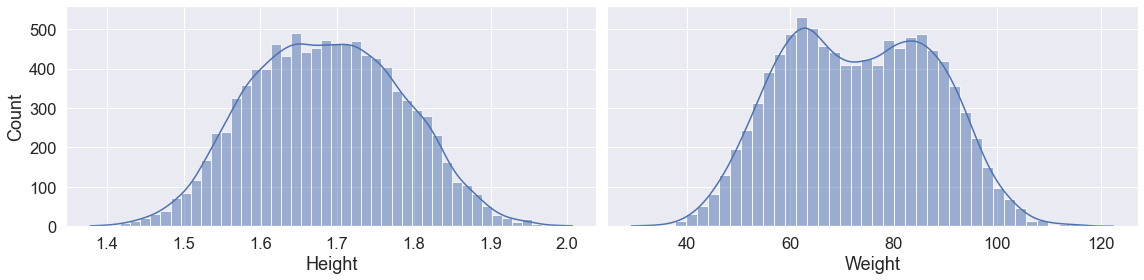

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(16,4))
sns.histplot(data=data, x='Height', kde=True, ax=ax1)
sns.histplot(data=data, x='Weight', kde=True, ax=ax2)
fig.tight_layout()

<AxesSubplot:xlabel='Weight', ylabel='Count'>

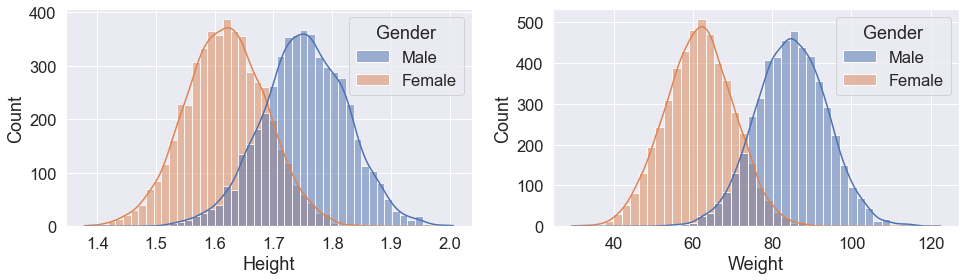

In [5]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
sns.histplot(data=data, x='Height', hue='Gender', kde=True, ax=ax1)
sns.histplot(data=data, x='Weight', hue='Gender', kde=True, ax=ax2)

# Print basic statistics wtih `describe`


In [6]:
display(data.describe())

,Height,Weight
count,10000.000000,10000.000000
mean,1.685739,73.215581
std,0.097727,14.561650
min,1.378286,29.342461
25%,1.613046,61.595488
50%,1.684482,73.112439
75%,1.757030,84.884138
max,2.006572,122.444308


# Z-score

In [7]:
from scipy.stats import zscore
# help(zscore)

In [8]:
# Compute z-score
data_with_z = data.join(data[['Height', 'Weight']].apply(zscore), rsuffix='_z_score')
data_with_z

,Gender,Height,Weight,Height_z_score,Weight_z_score
0,Male,1.875718,109.702296,1.944061,2.505797
1,Male,1.747064,73.610192,0.627537,0.027101
2,Male,1.882400,96.481114,2.012443,1.597806
3,Male,1.821970,99.792504,1.394060,1.825222
4,Male,1.775001,93.582676,0.913421,1.398750
...,...,...,...,...,...
9995,Female,1.680789,62.030591,-0.050660,-0.768151
9996,Female,1.703509,77.491114,0.181839,0.293631
9997,Female,1.622250,58.265451,-0.649688,-1.026730
9998,Female,1.753473,74.309506,0.693125,0.075127


## Outlier ratio

In [9]:

# compute outlier masks for Height and Weight
is_outlier_H = (data_with_z.Height_z_score.abs() > 3)
is_outlier_W = (data_with_z.Weight_z_score.abs() > 3)

# TODO complete to show the outlier count and ratio
# Display outlier count for height
outlier_count = ...
outlier_ratio = ...
print(
    f'Height outlier count: {outlier_count:d}/{data.shape[0]} '
    f'({outlier_ratio*100:0.5f}%)')
# Display the outlier count for width
outlier_count = ...
outlier_ratio = ...
print(
    f'Weight outlier count: {outlier_count:d}/{data.shape[0]} '
    f'({outlier_ratio*100:0.5f}%)')

TypeError: unsupported format string passed to ellipsis.__format__

**Note**: z-score can also be applied by group:

In [ ]:
data.join(data.groupby('Gender').apply(zscore), rsuffix='_z_score')

# Box-plots + interquartile range


## Whiskers at 1.5 IQR

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,5))
sns.boxplot(data=data, x='Height',orient='horiz', ax=ax1)
sns.boxplot(data=data, x='Weight',orient='horiz', ax=ax2)
fig.tight_layout()

## Whiskers at 3 IQR

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,5))
sns.boxplot(data=data, x='Height',orient='horiz', whis=3, ax=ax1)
sns.boxplot(data=data, x='Weight',orient='horiz', whis=3, ax=ax2)
fig.tight_layout()

## Outlier ratio

In [ ]:
q1 = data.quantile(0.25, interpolation='nearest')
q3 = data.quantile(0.75, interpolation='nearest')
IQR = q3-q1
IQR

In [ ]:
k = 1.5
lower, upper = q1-k*IQR, q3+k*IQR
lower, upper

In [ ]:
upper_outliers = data.Height > upper.loc['Height']
lower_outliers = data.Height < lower.loc['Height']
# TODO complete to retrieve outlier count and ratio
outilier_count = ...
outlier_ratio = ...
print(
    f'Height outlier count: {outilier_count:d}/{data.shape[0]} '
    f'({outlier_ratio*100:0.5f}%)')


In [ ]:
upper_outliers = data.Weight > upper.loc['Weight']
lower_outliers = data.Weight < lower.loc['Weight']
# TODO complete to retrieve outlier count and ratio
outilier_count = ...
outlier_ratio = ...
print(
    f'Weight outlier count: {outilier_count:d}/{data.shape[0]} '
    f'({outlier_ratio*100:0.5f}%)')


# Regression based methods

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
ax = axs[0]
ax.set_title('scatter+ regression line')
sns.regplot(
        data=data, x='Height', y='Weight',
        line_kws={"color": "C1"}, scatter_kws={"s": 10}, ax=ax)
ax = axs[1]
ax.set_title(f' residuals')
sns.residplot(
data=data, x='Height', y='Weight',
ax=ax)
fig.tight_layout()

## Cook's distance


In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import OLSInfluence

# fit the regression model using statsmodels library
f = 'Weight ~ Height'
model = ols(formula=f, data=data).fit()

# calculate the cooks_distance - the OLSInfluence object contains multiple influence measurements
cook_distance = OLSInfluence(model).cooks_distance
(distance, p_value) = cook_distance

## Outlier ratio

In [ ]:
# TODO complete to show the outlier count and ratio
threshold = 4/data.shape[0]
is_outlier = distance > threshold
outlier_count = ...
outlier_ratio = ...
print(f'At threshold 4/N = {threshold:0.5f}, '
      f'{outlier_count} samples are considered outliers '
      f'({outlier_ratio*100:0.2f}% of the samples)')

In [ ]:
# scatter plot - x axis (independent variable height), y-axis (dependent variable weight), size and color of the marks according to its cook's distance
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].set_title('Cook\'s distance')
sns.scatterplot(data=data, x="Height", y="Weight",
                hue=distance, size=distance, ax=axs[0],
                sizes=(50, 200), edgecolor='black', linewidth=1)


axs[1].set_title('Residual plot showing outliers')
sns.scatterplot(data=data, x="Height", y=model.resid, ax=axs[1],
                style=is_outlier, hue=is_outlier)
plt.show()


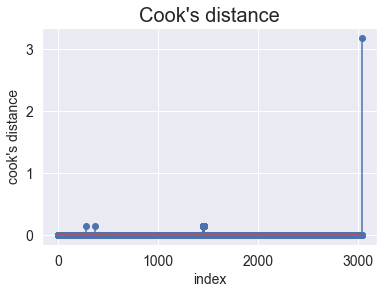

In [ ]:
threshold = 4/data.shape[0]

# stem plot - the x-axis represents the index of the observation and the y-axis its Cook's distance
plt.stem(distance, basefmt=" ")

# horizontal line showing the threshold value
plt.hlines(threshold, -2, 1+data.shape[0], 'r')

# the observations with Cook's distances higher than the threshold value are labeled in the plot
influencial_data = distance[distance > threshold]

# ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# labels and title
plt.xlabel('index', fontsize=14)
plt.ylabel('cook\'s distance', fontsize=14)
plt.title('Cook\'s distance', fontsize=20);

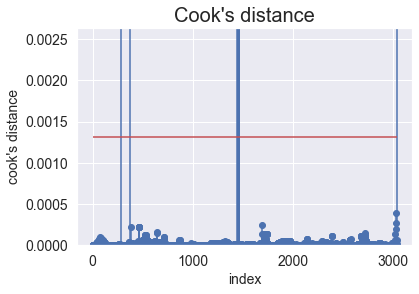

In [ ]:
# Zooming around the threshold
plt.stem(distance, basefmt=" ")
plt.hlines(threshold, -2, 1+data.shape[0], 'r')
plt.ylim(0,2*threshold)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# labels and title
plt.xlabel('index', fontsize=14)
plt.ylabel('cook\'s distance', fontsize=14)
plt.title('Cook\'s distance', fontsize=20);